**Objectives**

1. Data Augmentation:
    - Flip images horizontally & vertically.
    - Adjust pigmentation 
    - Change color hues.
    - Apply augmentation.

2. Research:
    - Find out suitable weather conditions for each fruit in the dataset.

3. Tell a Story:
Use the research & images to craft a short, clear narrative about the fruits (where they grow, best conditions)

#### **Import Necessary Libraries**

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from glob import glob
import shutil
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#### **Load the Training CSV File**

In [90]:
full_data = pd.read_csv("../input/fruit-classification-dataset/Fruit_dataset/train.csv")
full_data.columns = ['image', 'label']

full_data['image'] = data['image'].str.replace('train/', '', regex=False)
full_data.head()

,image,label
0,oil_palm/57.jpg,0
1,oil_palm/881.jpg,0
2,oil_palm/450.jpg,0
3,oil_palm/28.jpg,0
4,oil_palm/62.jpg,0


In [92]:
#Add the class name
with open("../input/fruit-classification-dataset/Fruit_dataset/classname.txt") as f:
    class_list = [line.strip() for line in f]

full_data['image_name'] = full_data['label'].apply(lambda x: class_list[x])

print(pd.concat([full_data.head(), full_data.tail()]))

                  image  label image_name
0       oil_palm/57.jpg      0   oil_palm
1      oil_palm/881.jpg      0   oil_palm
2      oil_palm/450.jpg      0   oil_palm
3       oil_palm/28.jpg      0   oil_palm
4       oil_palm/62.jpg      0   oil_palm
39995     emblic/86.jpg     99     emblic
39996     emblic/97.jpg     99     emblic
39997    emblic/149.jpg     99     emblic
39998    emblic/970.jpg     99     emblic
39999    emblic/874.jpg     99     emblic


#### **Splitting into Train and Validation**

In [95]:
train_data, val_data = train_test_split(full_data, train_size=0.8, stratify=full_data.label, random_state=42)
print(train_data.shape)
print(val_data.shape)

(32000, 3)
(8000, 3)


In [97]:
# Splitting Augmentation
data_augment, data_normal = train_test_split(train_data, train_size=0.4, stratify=train_data.label, random_state=42)
data_augment.head()

,image,label,image_name
27728,sapodilla/319.jpg,69,sapodilla
16724,mandarine/802.jpg,41,mandarine
16587,mandarine/482.jpg,41,mandarine
10230,chenet/636.jpg,25,chenet
28878,mango/629.jpg,72,mango


In [98]:
print(f"The shape of the augmented dataset is {data_augment.shape}")
print(f"The shape of the non-augmented dataset is {data_normal.shape}")
print(f"The shape of the validation dataset is {val_data.shape}")

The shape of the augmented dataset is (12800, 3)
The shape of the non-augmented dataset is (19200, 3)
The shape of the validation dataset is (8000, 3)


In [37]:
data_augment.label.value_counts()

label
13    160
9     160
87    160
64    160
29    160
     ... 
5     160
42    160
11    160
40    160
6     160
Name: count, Length: 100, dtype: int64

#### **Augmentation**

- Augment 25% (rotate, zoom, brightness, horizontal flip, rescale)

In [99]:
augmenter = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 67,
    zoom_range = [0.75, 1.25],
    brightness_range = [0.75, 1.25],
    horizontal_flip = True,
    vertical_flip = True
)

aug_flow = augmenter.flow_from_dataframe(
    dataframe = data_augment,
    directory= "../input/fruit-classification-dataset/Fruit_dataset/train1",
    x_col = "image",
    y_col = "image_name",
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True   
)

Found 12800 validated image filenames belonging to 100 classes.


In [100]:
rescaler = ImageDataGenerator(rescale = 1./255)

rsc_flow = rescaler.flow_from_dataframe(
    dataframe = data_normal,
    directory= "../input/fruit-classification-dataset/Fruit_dataset/train1",
    x_col = "image",
    y_col = "image_name",
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True   
)

Found 19200 validated image filenames belonging to 100 classes.


Join the 2 datasets together

In [101]:
def combined_generator(gen1, gen2):
    while True:
        x1, y1 = next(gen1)
        x2, y2 = next(gen2)

        # Combine along batch dimension
        x = np.concatenate((x1, x2), axis=0)
        y = np.concatenate((y1, y2), axis=0)

        yield x, y


full_train_data = combined_generator(aug_flow, rsc_flow)

#### **Rescaling for the Validation Dataset**

In [103]:
val_data.head()

,image,label,image_name
1425,sugar_apple/11.jpg,3,sugar_apple
6818,finger_lime/764.jpg,17,finger_lime
33329,papaya/437.jpg,83,papaya
11154,indian_strawberry/644.jpg,27,indian_strawberry
18062,fig/415.jpg,45,fig


In [107]:
val_flow = rescaler.flow_from_dataframe(
    dataframe = val_data,
    directory= "../input/fruit-classification-dataset/Fruit_dataset/train1",
    x_col = "image",
    y_col = "image_name",
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = True   
)

Found 8000 validated image filenames belonging to 100 classes.


#### **See some of the images ;)**

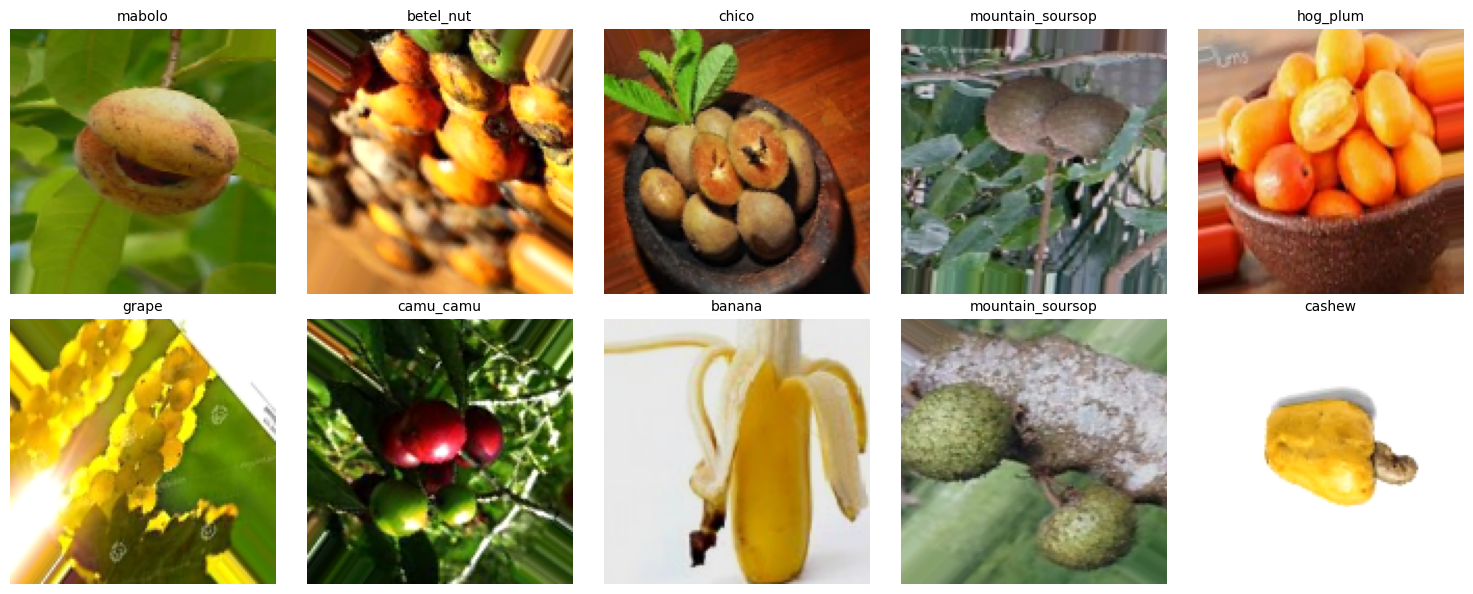

In [114]:
# Get class names from the generator
class_names = list(aug_flow.class_indices.keys())

# Set up the plot
plt.figure(figsize=(15, 6))

for i in range(10):
    img, label = next(aug_flow)  # Get one augmented image and label
    plt.subplot(2, 5, i + 1)
    plt.imshow(img[0])  # img is (1, 100, 100, 3), so img[0] is the actual image
    label_index = np.argmax(label[0])
    plt.title(f"{class_names[label_index]}", fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()


#### **The Model!!!!!!**

In [115]:
#  Deep CNN
model = Sequential([
    # Input Block - Reduced filters
    Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),
    
    # Second Conv Block - Reduced filters
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Third Conv Block - Removed one layer, reduced filters
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    
    # Simplified Fully Connected Layers
    Dense(128, activation='relu'),  # Reduced from 512 to 128
    Dropout(0.5),
    Dense(100, activation='softmax')
])

In [116]:
# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 126, 126, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 63, 63, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 61, 61, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 30, 30, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 28, 28, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 128)                 │       1,605,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 100)                 │          12,900 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,642,244 (6.26 MB)

 Trainable params: 1,642,244 (6.26 MB)

 Non-trainable params: 0 (0.00 B)

In [117]:
# === Callbacks for Model Training ===
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/fruit_model_1.h5', 
        monitor='val_loss',
        save_best_only=True
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='/kaggle/working/fruit_model_1.keras', 
        monitor='val_loss',
        save_best_only=True
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5,
        restore_best_weights=True
    )
]

print("\n--- Starting Model Training ---")



--- Starting Model Training ---


In [118]:
history = model.fit(
    full_train_data,
    epochs = 50,    
    steps_per_epoch = 500,
    callbacks = callbacks_list,
    verbose = 1,
    validation_data = val_flow
)


Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.0242 - loss: 4.4593

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


500/500 ━━━━━━━━━━━━━━━━━━━━ 154s 302ms/step - accuracy: 0.0242 - loss: 4.4589 - val_accuracy: 0.0959 - val_loss: 3.7571
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 137s 275ms/step - accuracy: 0.0737 - loss: 3.8487 - val_accuracy: 0.1374 - val_loss: 3.4854
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 132s 265ms/step - accuracy: 0.1053 - loss: 3.6056 - val_accuracy: 0.1644 - val_loss: 3.3009
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 142s 284ms/step - accuracy: 0.1308 - loss: 3.4730 - val_accuracy: 0.1890 - val_loss: 3.1902
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 281ms/step - accuracy: 0.1519 - loss: 3.3677 - val_accuracy: 0.2160 - val_loss: 3.0845
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - accuracy: 0.1659 - loss: 3.2709 - val_accuracy: 0.2266 - val_loss: 3.0305
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 126s 253ms/step - accuracy: 0.1790 - loss: 3.1974 - val_accuracy: 0.2355 - val_loss: 2.9850
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 124s 248ms/step - accuracy: 0.1923 - loss: 3.14

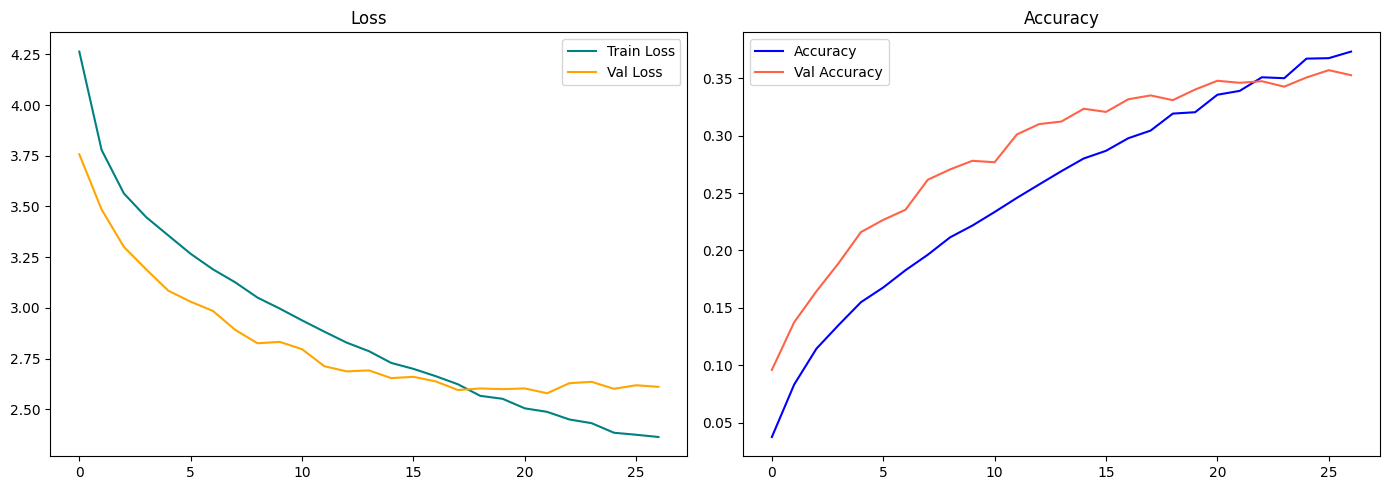

In [120]:
#Plot to show learning curve

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

sns.lineplot(data=history.history['loss'], ax=ax1, label='Train Loss', color='teal')
sns.lineplot(data=history.history['val_loss'], ax=ax1, label='Val Loss', color='orange')
ax1.set_title("Loss")

sns.lineplot(data=history.history['accuracy'], ax=ax2, label='Accuracy', color='blue')
if 'val_accuracy' in history.history:
    sns.lineplot(data=history.history['val_accuracy'], ax=ax2, label='Val Accuracy', color='tomato')
ax2.set_title("Accuracy")

plt.tight_layout()
plt.show()


#### **Testing time, blessing time!**

In [121]:
test_data = pd.read_csv("../input/fruit-classification-dataset/Fruit_dataset/val.csv")
test_data.columns = ['image', 'label']

test_data['image'] = test_data['image'].str.replace('val/', '', regex=False)

#Add the class name
with open("../input/fruit-classification-dataset/Fruit_dataset/classname.txt") as f:
    class_list = [line.strip() for line in f]

test_data['image_name'] = test_data['label'].apply(lambda x: class_list[x])

test_data.head()

,image,label,image_name
0,oil_palm/102.jpg,0,oil_palm
1,oil_palm/637.jpg,0,oil_palm
2,oil_palm/186.jpg,0,oil_palm
3,oil_palm/559.jpg,0,oil_palm
4,oil_palm/129.jpg,0,oil_palm


In [122]:
test_flow = rescaler.flow_from_dataframe(
    dataframe = test_data,
    directory= "../input/fruit-classification-dataset/Fruit_dataset/val1",
    x_col = "image",
    y_col = "image_name",
    target_size = (128,128),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False 
)

Found 5000 validated image filenames belonging to 100 classes.


In [123]:
loss, accuracy = model.evaluate(test_flow)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.3405 - loss: 2.5561
Test Loss: 2.5955467224121094
Test Accuracy: 0.3458000123500824
